#1.Data Collection & Preprocessing

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.preprocessing import *
from keras import *
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#importing dataset
df = pd.read_csv('/content/hotel_bookings.csv')

In [4]:
df.head(5)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,01-07-15
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,01-07-15
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,02-07-15
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,02-07-15
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,03-07-15


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

Checking nulls ,duplicates and cleaning

In [6]:
df.isnull().sum()

,0
hotel,0
is_canceled,0
lead_time,0
arrival_date_year,0
arrival_date_month,0
arrival_date_week_number,0
arrival_date_day_of_month,0
stays_in_weekend_nights,0
stays_in_week_nights,0
adults,0


In [ ]:
df.dropna()

#2. Analytics & Reporting

##Revenue trends over time

In [23]:
#Precompute monthly revenue and save to CSV


df['arrival_date'] = pd.to_datetime(
    df['arrival_date_year'].astype(str) + '-' +
    df['arrival_date_month'] + '-' +
    df['arrival_date_day_of_month'].astype(str),
    format='%Y-%B-%d'
)

#total
df['total_revenue'] = df['adr'] * (df['stays_in_weekend_nights'] + df['stays_in_week_nights'])
df.loc[df['is_canceled'] == 1, 'total_revenue'] = 0


monthly_revenue = df.groupby(pd.Grouper(key='arrival_date', freq='ME'))['total_revenue'].sum().reset_index()
monthly_revenue.to_csv('monthly_revenue.csv', index=False)

(array([0, 1, 2]),
 [Text(0, 0, '2015'), Text(1, 0, '2016'), Text(2, 0, '2017')])

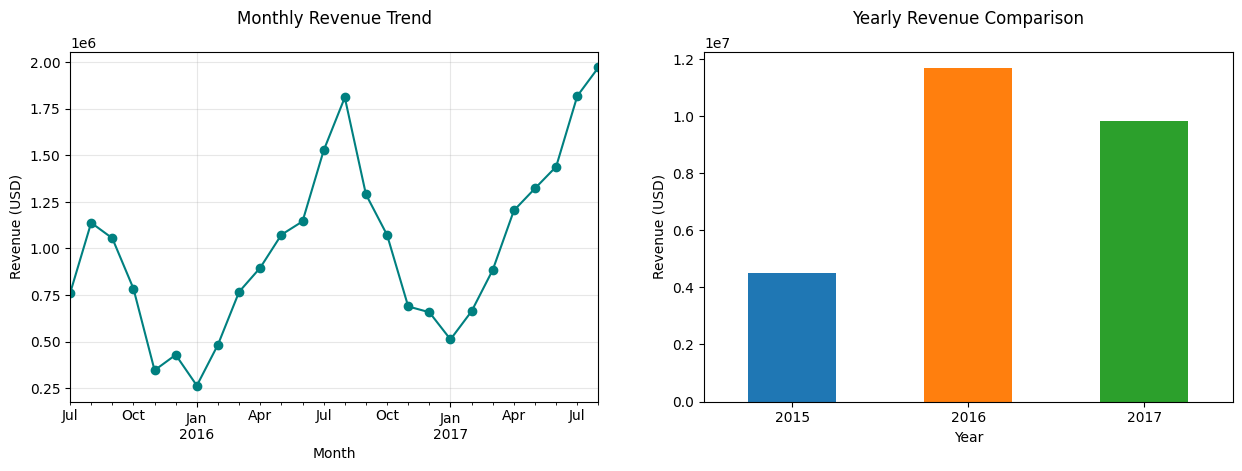

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



plt.figure(figsize=(15, 10))

# ----- Monthly Revenue Trend -----
plt.subplot(2, 2, 1)
monthly_revenue = df.groupby(pd.Grouper(key='arrival_date', freq='ME'))['total_revenue'].sum()
monthly_revenue.plot(kind='line', marker='o', color='teal')
plt.title('Monthly Revenue Trend', pad=20)
plt.xlabel('Month')
plt.ylabel('Revenue (USD)')
plt.grid(alpha=0.3)

# ----- Yearly Revenue Comparison -----
plt.subplot(2, 2, 2)
yearly_revenue = df.groupby('arrival_date_year')['total_revenue'].sum()
yearly_revenue.plot(kind='bar', color=['#1f77b4', '#ff7f0e', '#2ca02c'])
plt.title('Yearly Revenue Comparison', pad=20)
plt.xlabel('Year')
plt.ylabel('Revenue (USD)')
plt.xticks(rotation=0)





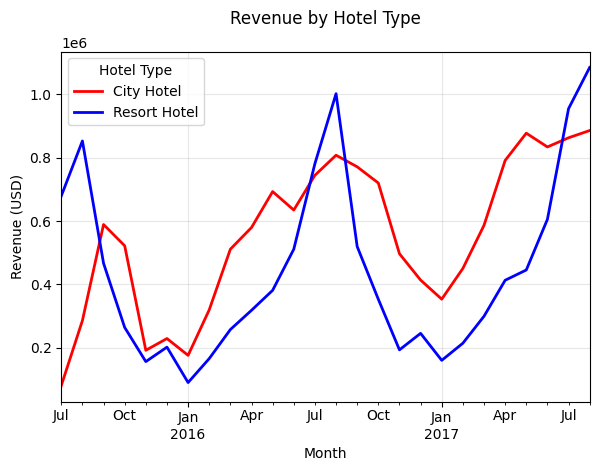

In [ ]:
# ----- Revenue by Hotel Type -----
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 3)
revenue_by_hotel = df.groupby([pd.Grouper(key='arrival_date', freq='ME'), 'hotel'])['total_revenue'].sum().unstack()
revenue_by_hotel.plot(ax=plt.gca(), style=['-r', '-b'], linewidth=2)
plt.title('Revenue by Hotel Type', pad=20)
plt.xlabel('Month')
plt.ylabel('Revenue (USD)')
plt.legend(title='Hotel Type')
plt.grid(alpha=0.3)

##Cancellation rate as percentage of total bookings

In [14]:
# Calculate & save overall cancellation rate
cancellation_rate = pd.DataFrame({
    'metric': ['cancellation_rate'],
    'value': [(df['is_canceled'].mean() * 100).round(1)]
})
cancellation_rate.to_csv('cancellation_rate.csv', index=False)


=== Cancellation Analysis ===
Total Bookings: 119,390
Cancelled Bookings: 44,224
Cancellation Rate: 37.0%


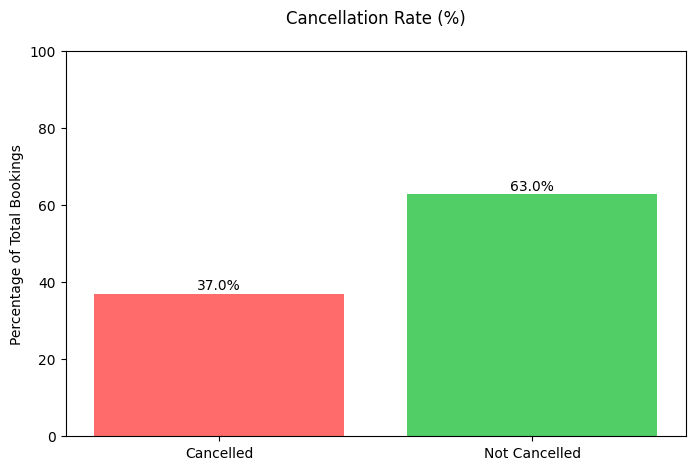

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Calculate Cancellation Rate
total_bookings = len(df)
cancelled_bookings = df['is_canceled'].sum()
cancellation_rate = (cancelled_bookings / total_bookings) * 100

# 2. Create Visualization
plt.figure(figsize=(8, 5))
plt.bar(['Cancelled', 'Not Cancelled'],
        [cancellation_rate, 100 - cancellation_rate],
        color=['#ff6b6b', '#51cf66'])

# Add percentage labels on top of bars
for i, value in enumerate([cancellation_rate, 100 - cancellation_rate]):
    plt.text(i, value + 1, f"{value:.1f}%", ha='center')

plt.title('Cancellation Rate (%)', pad=20)
plt.ylabel('Percentage of Total Bookings')
plt.ylim(0, 100)

# 3. Print Key Metrics
print(f"\n=== Cancellation Analysis ===")
print(f"Total Bookings: {total_bookings:,}")
print(f"Cancelled Bookings: {cancelled_bookings:,}")
print(f"Cancellation Rate: {cancellation_rate:.1f}%")

plt.show()

##Geographical distribution of users doing the bookings

In [16]:
# Get top 50 booking countries and save
country_dist = (
    df['country'].value_counts()
    .head(50)
    .reset_index()
    .rename(columns={'index': 'country', 'country': 'booking_count'})
)
country_dist.to_csv('geographical_distribution.csv', index=False)

In [17]:
df['country'].value_counts()

,count
country,
PRT,48590
GBR,12129
FRA,10415
ESP,8568
DEU,7287
...,...
MRT,1
KIR,1
SDN,1


In [ ]:
df['country'].nunique()

177

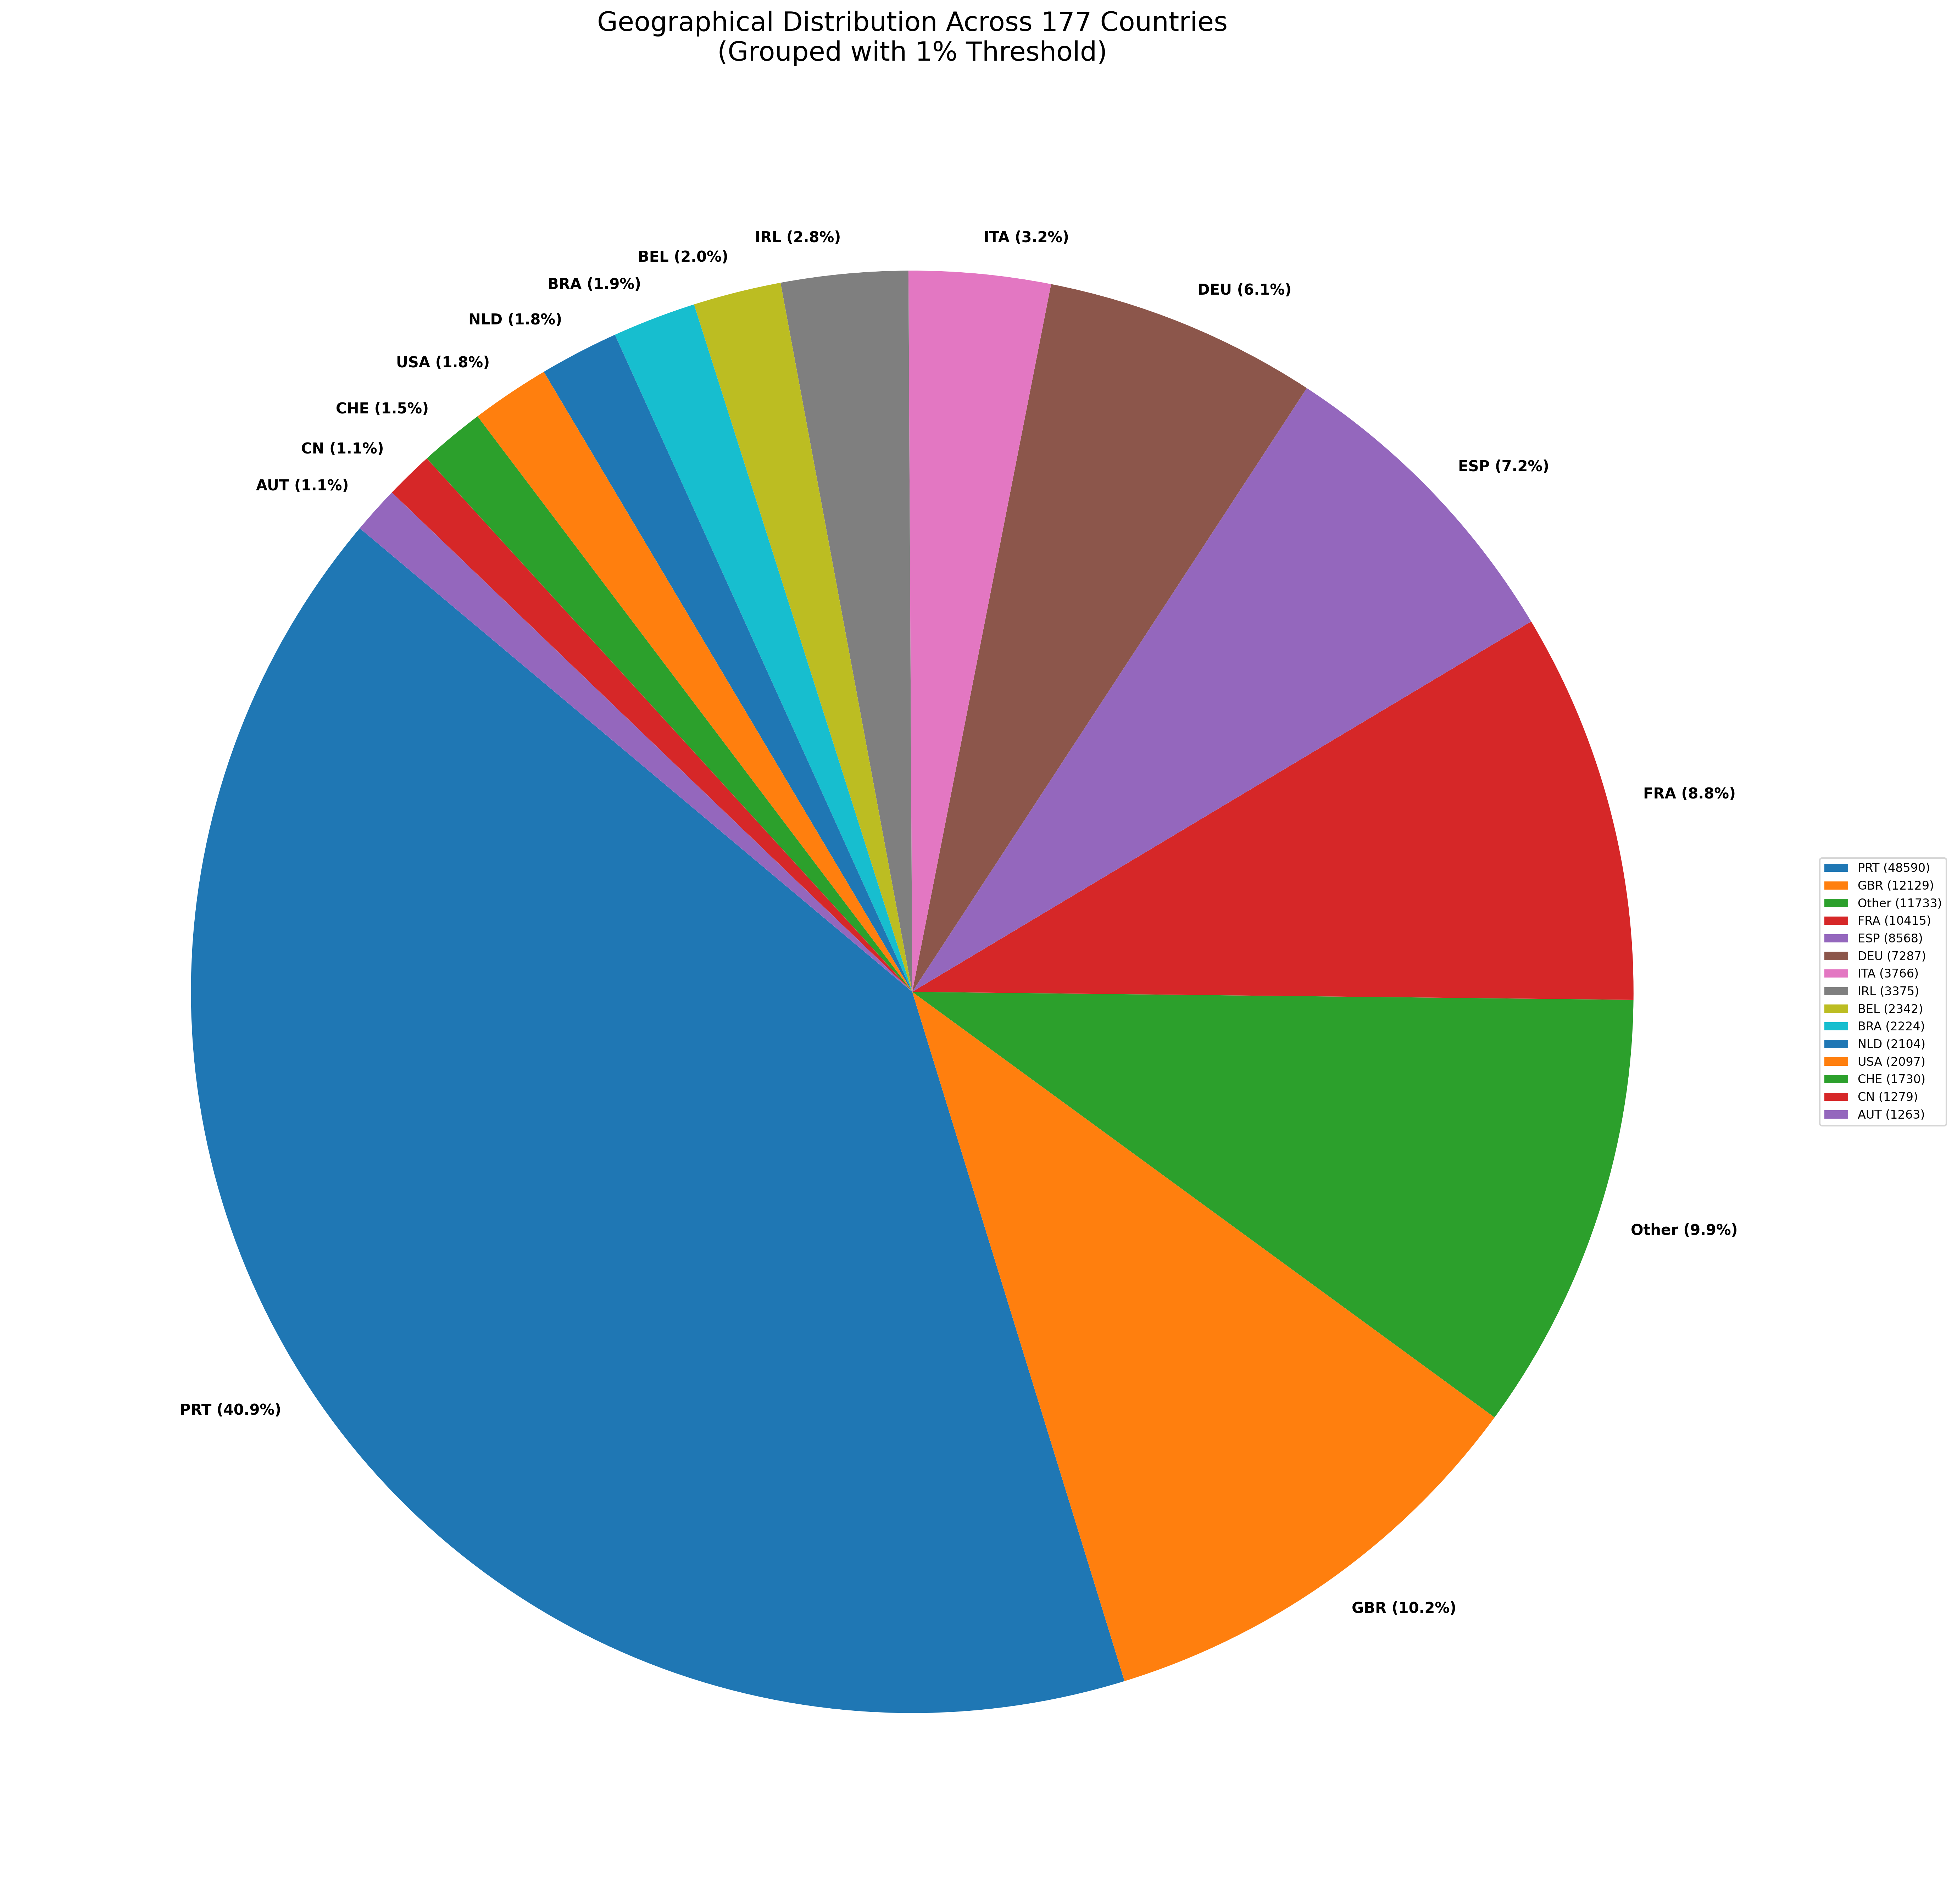

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
from textwrap import wrap

# Prepare data
country_counts = df['country'].value_counts()
total = country_counts.sum()

# Group small countries into 'Other' (adjust threshold as needed)
threshold = total * 0.01  # 1% threshold
main_countries = country_counts[country_counts >= threshold]
other_count = country_counts[country_counts < threshold].sum()
main_countries['Other'] = other_count

# Sort by value (descending)
main_countries = main_countries.sort_values(ascending=False)

# Create figure with large size
plt.figure(figsize=(24, 18), dpi=300)

# Generate custom labels with percentages
labels = [f"{country}\n({count/total:.1%})" for country, count in main_countries.items()]

# Wrap long country names
labels = ['\n'.join(wrap(label, 15)) for label in labels]

# Create pie chart
# The line below was changed to remove the 'autotexts' variable.
# plt.pie() returns only patches and texts when autopct is not used.
patches, texts = plt.pie(
    main_countries,
    labels=labels,
    startangle=140,
    pctdistance=0.85,
    labeldistance=1.05,
    textprops={'fontsize': 10}
)

# Improve label readability
plt.setp(texts, size=10, weight="bold")
# The line below was removed because there is no 'autotexts' to format.
# plt.setp(autotexts, size=9, color="white")

# Add legend for smaller segments (optional)
plt.legend(
    patches,
    [f"{country} ({count})" for country, count in main_countries.items()],
    loc="center left",
    bbox_to_anchor=(1, 0.5),
    fontsize=8
)

plt.title('Geographical Distribution Across 177 Countries\n(Grouped with 1% Threshold)',
          fontsize=18, pad=20)
plt.tight_layout()

# Save high-resolution version
plt.savefig('country_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

##Booking Lead time distribution

In [22]:
# Categorize lead times and save counts
lead_time_bins = [0, 7, 30, 90, 180, 365, float('inf')]
lead_time_labels = ['0-7 days', '1-4 weeks', '1-3 months', '3-6 months', '6-12 months', '>1 year']

lead_time_dist = (
    pd.cut(df['lead_time'], bins=lead_time_bins, labels=lead_time_labels)
    .value_counts()
    .reset_index()
    .rename(columns={'index': 'lead_time_window', 'lead_time': 'booking_count'})
)
lead_time_dist.to_csv('lead_time_distribution.csv', index=False)


=== Lead Time Statistics ===
Average lead time: 104.0 days
Median lead time: 69.0 days
Minimum lead time: 0 days
Maximum lead time: 737 days
Bookings > 1 year lead time: 3148

Percentiles:
count    119390.000000
mean        104.011416
std         106.863097
min           0.000000
25%          18.000000
50%          69.000000
75%         160.000000
90%         265.000000
95%         320.000000
max         737.000000
Name: lead_time, dtype: float64


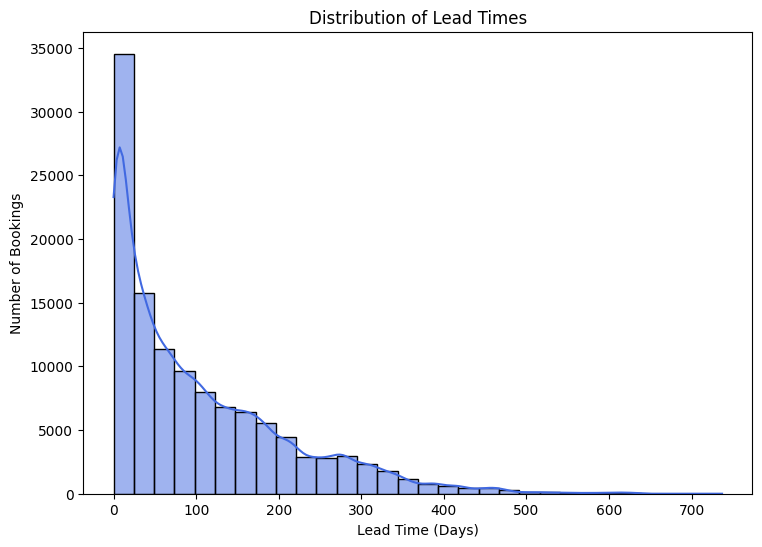

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the plot style
#plt.style.use('seaborn')
plt.figure(figsize=(19, 6))

# 1. Basic Distribution Plot
plt.subplot(1, 2, 1)
sns.histplot(df['lead_time'], bins=30, kde=True, color='royalblue')
plt.title('Distribution of Lead Times')
plt.xlabel('Lead Time (Days)')
plt.ylabel('Number of Bookings')



# 3. Key Statistics
print("\n=== Lead Time Statistics ===")
print(f"Average lead time: {df['lead_time'].mean():.1f} days")
print(f"Median lead time: {df['lead_time'].median():.1f} days")
print(f"Minimum lead time: {df['lead_time'].min()} days")
print(f"Maximum lead time: {df['lead_time'].max()} days")
print(f"Bookings > 1 year lead time: {(df['lead_time'] > 365).sum()}")

# 4. Percentile Analysis (Optional)
print("\nPercentiles:")
print(df['lead_time'].describe(percentiles=[.25, .5, .75, .9, .95]))

##Room Type Preference

In [30]:
# Analyze room type popularityand save to csv
room_preference = (
    df['reserved_room_type'].value_counts()
    .reset_index()
    .rename(columns={'index': 'room_type', 'reserved_room_type': 'booking_count'})
)
room_preference.to_csv('room_type_preference.csv', index=False)

In [36]:
# Load precomputed data
room_data = pd.read_csv('room_type_preference.csv')
room_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   booking_count  10 non-null     object
 1   count          10 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 292.0+ bytes
